In [1]:
# this notebook is trying to see what it takes to run the full model 
# (two lithologies, width-dependent transport, lateral sediment, etc.)
# to steady state, albeit on a downsized grid

In [2]:
# start with just the math, and steps

## What steps are we following in our model?

### Outside of the loop:
1. Define parameters
- grid spacing $(x)$
- length of domain $(dx)$

- runoff rate $(r)$
- Hack coefficient for basin shape $(k_h)$
- Hack exponent for basin shape $(h)$

- characteristic sediment thickness $(H^*)$

- igneous abrasion coeffcient $(\beta)$
- attrition factor (same as igneous abrasion coeff) $(\psi)$
- erodibility $(K)$

- fraction of "hillslope" / "tributary" material that is coarse $(\gamma)$

- valley width coefficient $(k_{x, B})$
- valley width exponent $(P_{x, B})$
- channel width coefficient $(k_b)$

- porosity $(\phi)$
- grain size $(D)$

- uplift rate $(U)$

2. Set up arrays
- sediment $(H)$
- bedrock $(\eta_b)$
- topography $(\eta)$

3. Calculate constant, derivative values
- total discharge $(Q)$
- valley width $(B)$

### Within the function but before the loop:
1. Define constants (not tunable parameters)
- c
- I
2. Calculate dt
3. Define arrays
- channel width $(b)$
- bedrock erosion $(E_b)$
- sedimentation rate $(E_H)$
- total erosion rate $(E)$
- unit discharge $(q)$
- total sediment transport $(Q_s)$
- unit sediment transport $(q_s)$
- lateral sediment transport $(ql)$
4. Set boundary conditions for $b$, $H$, $E$, $q$, and $q_l$

### Within the loop:
1. Calculate slope using topography $(S)$
- Have started with tiny slope so that we don't get "divide by 0" errors
2. Calculate channel width $(b)$
3. Calculate unit discharge $(q)$
- total discharge divided by channel width
4. Calculate bed cover $(\alpha)$
5. Calculate sediment transport
- total sed transport is W&S Eqn 17 $(Q_s)$
- unit sed transport is total transport divided by valley width $(q_s)$
6. Calculate bedrock erosion via plucking and abrasion
- These processes only occur in the channel (multiply by channel width?)
7. Calculate attrition
- This process happens in the channel, over the unit flux?
8. Calculate lateral sediment inputs
9. Calculate sedimentation rate
- This occurs over the valley width, idea being that over long timescales the entire valley aggrades or incises at roughly the same rate
10. Calculate total erosion rate
- Bedrock erosion minus sedimentation
11. Update topography

In [3]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [4]:
# define parameters

dx = 1000 # grid spacing
x = np.arange(0, 10000, dx) # domain length
r = 10. # runoff rate
kh = 1/3 # hack coefficient
h = 2 # hack exponent
Hstar = 0.5 # characteristic sediment thickness
beta = np.zeros(len(x))
beta[:3] = 0.0004
beta[3:] = 0.004
# beta = 0.00004 # igneous abrasion coefficient
psi = 0.00004 # attrition factor
K = np.zeros(len(x))
K[:3] = 0.000001
K[3:] = 0.00001
# K = 0.0001 # rock erodibility
# gamma = 0.5 # fraction of coarse sediment from hillslope erosion
gamma = np.zeros(len(x))
gamma[:3] = 0.5
kxb = 25 # valley width coefficient
Pxb = 1/5 # valley width exponent
kb = 8.3e-8 # channel width coefficient
phi = 0.55 # sediment porosity
D = 0.05 # grain size
U = 0.00005

In [5]:
# set up arrays

H = Hstar + np.zeros(len(x)) # sediment thickness
etab = np.zeros(len(x)) # bedrock elevation array
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
eta = etab + H # total topographic elevation

In [6]:
# calculate constant, derivative values

B = kxb * (x**Pxb) # valley width
# Q = r * kh * (x**h) # total discharge
Q = r * B * x

In [7]:
B

array([  0.        ,  99.52679264, 114.32626298, 123.98360491,
       131.32639022, 137.32006791, 142.41976301, 146.87896944,
       150.85440841, 154.45021264])

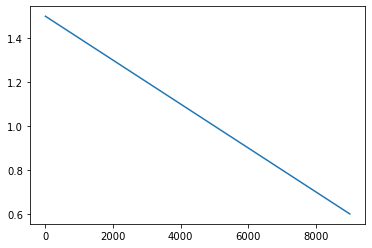

In [8]:
plt.plot(x, eta)

In [9]:
def model(x,
          dx,
          Hstar,
          H,
          etab,
          eta,
          beta,
          psi,
          K,
          gamma,
          kxb,
          Pxb,
          kb,
          phi,
          D,
          U,
          Q,
          B,
          num_steps = 1000000):
    
    # define more constants
    kqs = 0.041 # sediment discharge coefficient
    I = 0.01 # intermittency factor
    
    # calculate timestep
    dt_global = 0.2 * (0.2 * dx * dx / (kqs*Q[-1]))
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time
    
    # define arrays
    b = np.zeros(len(x)) # channel width
    Eb_p = np.zeros(len(x)) # plucking rate
    Eb_a = np.zeros(len(x)) # abrasion rate
    Eb = np.zeros(len(x)) # bedrock erosion rate
    Eh = np.zeros(len(x)) # sedimentation rate
    E = np.zeros(len(x)) # total erosion rate
    q = np.zeros(len(x)) # unit discharge
    Qs = np.zeros(len(x)) # total sediment transport
    qs = np.zeros(len(x)) # unit sediment transport
    ql = np.zeros(len(x)) # lateral sediment supply
    
    # set boundary conditions
    b[0] = 0
    H[-1] = 0
    E[-1] = U/5
    q[0] = 0
    Qs[0] = 0
    qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        
        # first calculate rates
            
        # calculate slope
        S = np.abs(np.diff(eta)/dx)
        
        # calculate channel width (L)
        b = (kb * Q[1:] * (S ** (7 / 6))) / (D**(3/2))
        
        # calculate unit discharge (L^2/T)
        q[1:] = Q[1:]/b
        
        # calculate bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calculate sediment transport (L^3/T and L^2/T)
        # Qs[1:] = c * I * Q[1:] * S**(7/6) * (1 - alpha[:-1])
        Qs[1:] = kqs * I * Q[1:] * np.sign(S) * (np.abs(S)) ** (7/6) * (1-alpha[:-1])
        qs[1:] = Qs[1:]/b
        
        # calculate individual erosion mechanism rates (L^2/T)
        Eb_p[:-1] = K[1:] * Q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta[1:] * Qs[1:] * alpha[:-1]
        
        # calculate total bedrock erosion rate (L/T)
        # Eb[:-1] = Eb_p[:-1] + Eb_a[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B[1:]
        
        # calculate attrition rate (L^2/T)
        atr = beta * Qs
        
        # calculate lateral sediment inputs (L^2/T)
        # ql = ((Eb * gamma) / beta) * (1 - np.exp(-beta * (x/3)))
        # using U is fine for experimenting now, but will eventually need to become a weighted average
        # of past values of total E
        ql = ((U * gamma) / beta) * (1 - np.exp(-beta * (x/3)))
        
        # calculate sedimentation rate (L/T)
        Eh[:-1] = - (1/ ((1 - phi) * B[1:])) * ((np.diff(Qs)/dx) + atr[1:] - Eb_p[:-1] - ql[:-1])
        #Eh[1:] = - (1/ (1 - phi) * B[1:]) * ((np.diff(Qs)/dx) + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calculate total erosion rate (L/T)
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        
        
        
        # Calculate maximum allowable time-step size
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(E)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(Eh < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/Eh[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        
        # Update quantities
        
        # update boundary conditions
        eta[-1] -= U * dt
        etab[-1] = eta[-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] += Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
#         print(dt, "chosen timestep in years")
#         print(dt_global, "global timestep")
#         print(min_time_to_flat, "time to flat")
#         print(min_time_to_no_sed, "time to no sed")
        
        if any(E[:] != U):
            continue
        else:
            break
            
    print(cum_time, "years")
        
    return (S, b, q, Qs, qs, Eb, atr, ql, Eh, E, eta, etab, H, dt)

In [10]:
test_run = [x, dx, Hstar, H, etab, eta, beta, psi, K, gamma, kxb, Pxb, kb, phi, D, U, Q, B]

In [11]:
(S, b, q, Qs, qs, Eb, atr, ql, Eh, E, eta, etab, H, dt) = model(*test_run)

70185.13526151761 years


In [12]:
E

array([2.40154593e-05, 1.34516126e-04, 2.44687297e-05, 1.11212095e-05,
       1.36925009e-05, 3.15406143e-05, 3.84753322e-05, 4.67978448e-05,
       4.95859440e-05, 1.00000000e-05])

In [13]:
Eb

array([2.48832821e-05, 2.28949597e-14, 3.18670273e-09, 3.97459207e-06,
       1.11195312e-05, 2.87270034e-05, 3.82857554e-05, 4.64266130e-05,
       4.93661528e-05, 0.00000000e+00])

In [14]:
Eh

array([-8.67822872e-07,  1.34516126e-04,  2.44655430e-05,  7.14661747e-06,
        2.57296972e-06,  2.81361089e-06,  1.89576743e-07,  3.71231826e-07,
        2.19791290e-07,  0.00000000e+00])

In [15]:
ql

array([0.        , 0.00780167, 0.01462948, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

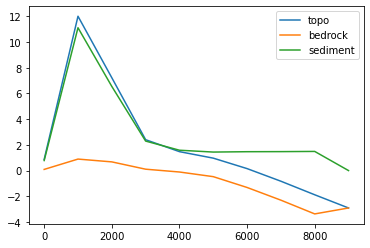

In [16]:
plt.plot(x, eta, label = 'topo')
plt.plot(x, etab, label = 'bedrock')
plt.plot(x, H, label = 'sediment')
plt.legend()

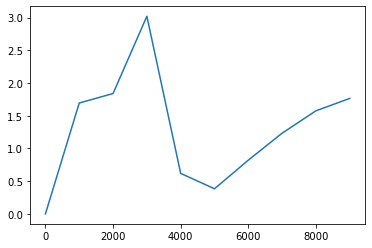

In [17]:
plt.plot(x, Qs)

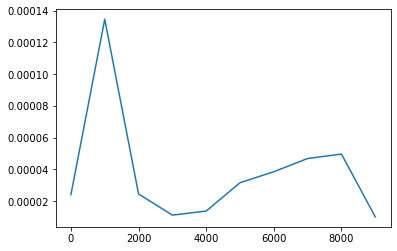

In [18]:
plt.plot(x, E)

In [37]:
# okay, so we're almost to steady state
# began: 6:48 am
# finished: 

In [38]:
# scratch code
# def model(x,
#           dx,
#           Hstar,
#           H,
#           etab,
#           eta,
#           beta,
#           psi,
#           K,
#           gamma,
#           kxb,
#           Pxb,
#           kb,
#           phi,
#           D,
#           U,
#           Q,
#           B,
#           num_steps = 8000000):
    
#     # define more constants
#     kqs = 0.041 # sediment discharge coefficient
#     I = 0.01 # intermittency factor
    
#     # calculate timestep
#     dt = 0.2 * (0.2 * dx * dx / (kqs*Q[-1]))
    
#     # define arrays
#     b = np.zeros(len(x)) # channel width
#     Eb_p = np.zeros(len(x)) # plucking rate
#     Eb_a = np.zeros(len(x)) # abrasion rate
#     Eb = np.zeros(len(x)) # bedrock erosion rate
#     Eh = np.zeros(len(x)) # sedimentation rate
#     E = np.zeros(len(x)) # total erosion rate
#     q = np.zeros(len(x)) # unit discharge
#     Qs = np.zeros(len(x)) # total sediment transport
#     qs = np.zeros(len(x)) # unit sediment transport
#     ql = np.zeros(len(x)) # lateral sediment supply
    
#     # set boundary conditions
#     b[0] = 0
#     H[-1] = 0
#     E[-1] = U
#     q[0] = 0
#     Qs[0] = 0
#     qs[0] = 0
#     ql[0] = 0
    
#     for i in range(num_steps):
        
#         # update boundary conditions
#         eta[-1] -= U * dt
#         etab[-1] = eta[-1]
        
#         # calculate slope
#         S = np.abs(np.diff(eta)/dx)
        
#         # calculate channel width (L)
#         # b = (kb * Q[1:] * (S**(7/6))) / (D**(3/2))
#         b = (kb * Q[1:] * (S ** (7 / 6))) / (D**(3/2))
        
#         # calculate unit discharge (L^2/T)
#         q[1:] = Q[1:]/b
        
#         # calculate bed exposure
#         alpha = np.exp(-H/Hstar)
        
#         # calculate sediment transport (L^3/T and L^2/T)
#         # Qs[1:] = c * I * Q[1:] * S**(7/6) * (1 - alpha[:-1])
#         Qs[1:] = kqs * I * Q[1:] * np.sign(S) * (np.abs(S)) ** (7/6) * (1-alpha[:-1])
#         qs[1:] = Qs[1:]/b
        
#         # calculate bedrock erosion rates (L^2/T)
#         Eb_p[:-1] = K * Q[1:] * S * alpha[:-1]
#         Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        
#         # Eb[:-1] = Eb_p[:-1] + Eb_a[:-1]
#         Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B[1:]
        
#         # calculate attrition rate (L^2/T)
#         atr = beta * Qs
        
#         # calculate lateral sediment inputs (L/T)... needs to be L^2/T
#         ql = ((Eb * gamma) / beta) * (1 - np.exp(-beta * (x/3)))
        
#         # calculate sedimentation rate (L/T)
#         Eh[:-1] = - (1/ (1 - phi) * B[1:]) * ((np.diff(Qs)/dx) + atr[1:] - Eb_p[:-1] - ql[:-1])
#         #Eh[1:] = - (1/ (1 - phi) * B[1:]) * ((np.diff(Qs)/dx) + atr[1:] - Eb_p[:-1] - ql[:-1])
        
#         # calculate total erosion rate
#         E[:-1] = Eb[:-1] + Eh[:-1]
        
#         # update topography
#         etab[:-1] -= Eb[:-1] * dt
#         H[:-1] += Eh[:-1] * dt
#         H[H<0] = 0
#         eta[:-1] = etab[:-1] + H[:-1]
        
#     return (S, b, q, Qs, qs, Eb, atr, ql, Eh, E, eta, etab, H, dt)